<a href="https://www.kaggle.com/code/minhvngc/exploration?scriptVersionId=99484747" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

- Overview: The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.

- Goal: Analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to <b>predict revenue per customer</b>

- Data format: 
    + Each row in the dataset is one visit to the store. 
    + <b>Not all rows in test_v2.csv will correspond to a row in the submission</b>, but all unique fullVisitorIds will correspond to a row in the submission.
    + Due to the formatting of fullVisitorId you must <b>load the Id's as strings in order for all Id's to be properly unique!</b>
    + There are multiple columns which contain JSON blobs of varying depth. In one of those JSON columns, totals, the sub-column transactionRevenue contains the revenue information we are trying to predict. This sub-column exists only for the training data.


- Data train: user transactions which are collected from GStore around the world 01/08/2016 to 30/04/2018.
- Data test: ALL users' transactions in the future time.
 + Public LB: is being calculated for those visitors during the same timeframe of 01/05/2018 to 15/10/2018
 + Private LB: is being calculated on the future-looking timeframe of 01/12/2018 to 31/01/2019 - for those **same** set of users. 
 
 $\Rightarrow$ Therefore, your submission that is intended for the public LB timeframe will be different from the private LB timeframe, which will be rescored/recalculated on the future timeframe.
 
 
- Input: All transactions of a user from 01/08/2016 to 30/04/2018.
- Output: Total revenue of that user during the predicting time.
 
 We are predicting the <b>natural log of the sum of all transactions per user</b>. 
 
$$
y_{user} = \sum_{i=1}^{n} transaction_{user_i} 
$$
$$
target_{user} = \ln({y_{user}+1})
$$
 

- External Data: is <b>permitted</b> for this competition. This includes the <a href="https://support.google.com/analytics/answer/6367342#access&zippy=%2Cin-this-article">Google Merchandise Store Demo Account</a>. Although the Demo Account contains the predicted variable, final standings will not benefit from access to this external data, because it requires future-looking predictions.

- Evaluation Metric

Submissions are scored on the root mean squared error. RMSE is defined as:

$$ \text{RMSE} = \sqrt{\frac{1}{n}\sum^n_{i=1}(y_i - \hat{y}_i)^2} $$

# 1. Data exploration

In [1]:
import numpy as np
import pandas as pd
import os
import json
from pandas.io.json import json_normalize
from scipy.stats import norm
import datetime
# Seaborn and matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
# Plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
init_notebook_mode(connected=True)

import gc
gc.enable()

dir = '../input/ga-customer-revenue-prediction/'
for _, _, filenames in os.walk(dir):
    for filename in filenames:
        print(filename)

sample_submission.csv
train_v2.csv
test_v2.csv
sample_submission_v2.csv
train.csv
test.csv


 <b>train_v2.csv</b>: the updated training set - contains user transactions from August 1st 2016 to April 30th 2018.
 
 <b>test_v2.csv</b>: the updated test set - contains user transactions from May 1st 2018 to October 15th 2018.
 
 <b>sample_submission_v2.csv</b> - a updated sample submission file in the correct format. Contains all fullVisitorIds in test_v2.csv. Your submission's PredictedLogRevenue column should make forward-looking predictions for each of these fullVisitorIds for the timeframe of December 1st 2018 to January 31st 2019.

Columns:
- `fullVisitorId`: A unique identifier for each user of the Google Merchandise Store.
- `channelGrouping`: The channel via which the user came to the Store.
- `date`: The date on which the user visited the Store.
- `device`: The specifications for the device used to access the Store.
- `geoNetwork`: This section contains information about the geography of the user.
- `socialEngagementType`: Engagement type, either "Socially Engaged" or "Not Socially Engaged".
- `trafficSource`: This section contains information about the Traffic Source from which the session originated.
- `visitId`: An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a <b>completely unique ID</b>, you should use a combination of fullVisitorId and visitId.
- `visitNumber`: The session number for this user. If this is the first session, then this is set to 1.
- `visitStartTime`: The timestamp (expressed as POSIX time).
- `hits`: This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.
- `customDimensions`: This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.
- `totals`: This set of columns mostly includes high-level aggregate data, contains aggregate values across the session.

# 1.1 Explore data v1

Based on: https://www.kaggle.com/code/jsaguiar/complete-exploratory-analysis-all-columns/notebook 

In [2]:
def load_df(file_name = 'train.csv', nrows = None):
    """ Read csv and convert json columns. Author: Julián Peller. """
    
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv('../input/{}'.format(file_name),
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

In [3]:
%%time
train, test = load_df(dir + 'train.csv'), load_df(dir + 'test.csv')
train.head()

CPU times: user 2min 16s, sys: 16.4 s, total: 2min 33s
Wall time: 2min 52s


,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserVersion,...,trafficSource_adwordsClickInfo.criteriaParameters,trafficSource_isTrueDirect,trafficSource_referralPath,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adContent,trafficSource_campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,not available in demo dataset,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Train set has 55 columns and the test set has 53 columns
- Extra columns are: totals_transactionRevenue (our target variable) and trafficSource_campaignCode

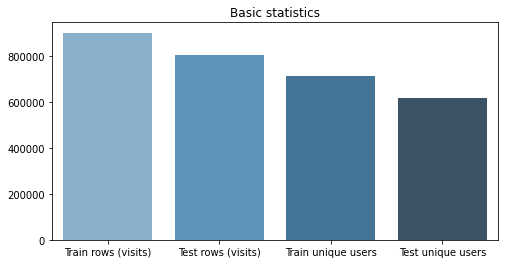

In [4]:
values_name = ['Train rows (visits)', 'Test rows (visits)', 'Train unique users', 'Test unique users']
values = [len(train), len(test), train['fullVisitorId'].nunique(), test['fullVisitorId'].nunique()]
plt.figure(figsize=(8,4))
plt.title("Basic statistics")
ax = sns.barplot(x=values_name, y=values, palette='Blues_d')

### 1.1.1 Target variable

The <b>'totals_transactionRevenue'</b> column has the transaction value for each visit. However, our train set has 98.72% of missing values for revenue which we can consider as zero revenue (no purchase). 

Based on this discussion(https://www.kaggle.com/competitions/ga-customer-revenue-prediction/discussion/65775) the revenue unit is <b>million USD (10^6)</b>.

totals_transactionRevenue has 11515 non-missing values or 1.274% (train set)
Only 9996 unique users have transactions or 0.014% (train set)


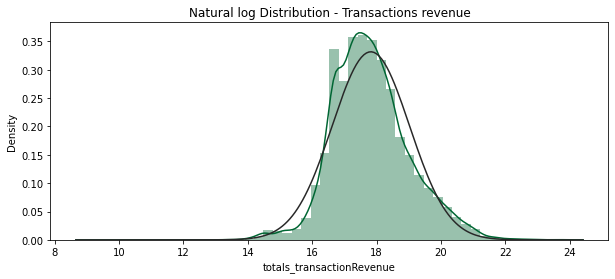

In [5]:
non_missing = len(train[~train['totals_transactionRevenue'].isnull()])
num_visitors = train[~train['totals_transactionRevenue'].isnull()]['fullVisitorId'].nunique()
print("totals_transactionRevenue has {} non-missing values or {:.3f}% (train set)"
      .format(non_missing, 100*non_missing/len(train)))
print("Only {} unique users have transactions or {:.3f}% (train set)"
      .format(num_visitors, num_visitors/train['fullVisitorId'].nunique()))
# Logn Distplot
revenue = train['totals_transactionRevenue'].dropna().astype('float64')
plt.figure(figsize=(10,4))
plt.title("Natural log Distribution - Transactions revenue")
ax1 = sns.distplot(np.log(revenue), color="#006633", fit=norm)

# Fill missing with 0 and convert to numerical
train['totals_transactionRevenue'] = train['totals_transactionRevenue'].fillna(0).astype('int64')

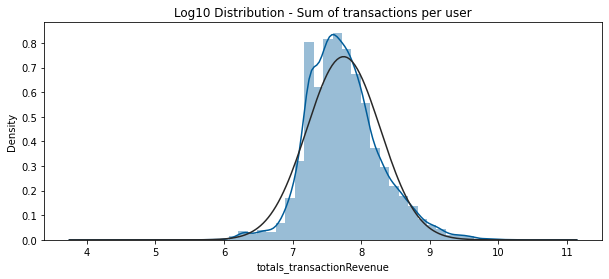

In [6]:
g = train[train['totals_transactionRevenue'] > 0][['fullVisitorId', 'totals_transactionRevenue']]
sum_transactions = g.groupby('fullVisitorId')['totals_transactionRevenue'].sum()
plt.figure(figsize=(10,4))
plt.title("Log10 Distribution - Sum of transactions per user")
ax1 = sns.distplot(np.log10(sum_transactions), color="#005c99", fit=norm)

### 1.1.2 Time series

In [7]:
def convert_to_datetime(frame):
    frame['date'] = frame['date'].astype(str)
    frame['date'] = frame['date'].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
    frame['date'] = pd.to_datetime(frame['date'])
    return frame

train = convert_to_datetime(train)
test = convert_to_datetime(test)

In [8]:
# Visits by time train
tmp_train = train['date'].value_counts().to_frame().reset_index().sort_values('index')
tmp_train = tmp_train.rename(columns = {"date" : "visits"}).rename(columns = {"index" : "date"})
# Visits by time test
tmp_test = test['date'].value_counts().to_frame().reset_index().sort_values('index')
tmp_test = tmp_test.rename(columns = {"date" : "visits"}).rename(columns = {"index" : "date"})
# Plot visits
trace1 = go.Scatter(x=tmp_train.date.astype(str), y=tmp_train.visits,
                    opacity = 0.8, line = dict(color = '#ff751a'), name= 'Train')
trace2 = go.Scatter(x=tmp_test.date.astype(str), y=tmp_test.visits,
                    opacity = 0.8, line = dict(color = '#75a3a3'), name= 'Test')
traces = [trace1, trace2]

layout = dict(
    title= "Visits by date",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date'
    )
)

fig = dict(data= traces, layout=layout)
iplot(fig)


# Revenue by time
train_date_sum = train.groupby('date')['totals_transactionRevenue'].sum().to_frame().reset_index()
# Plot
trace_date = go.Scatter(x=train_date_sum.date.astype(str), 
                        y=train_date_sum['totals_transactionRevenue'].apply(lambda x: np.log(x)), opacity = 0.8)
layout = dict(
    title= "Log Revenue by date",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date'
    )
)

fig = dict(data= [trace_date], layout=layout)
iplot(fig)

### 1.1.3 Missing values

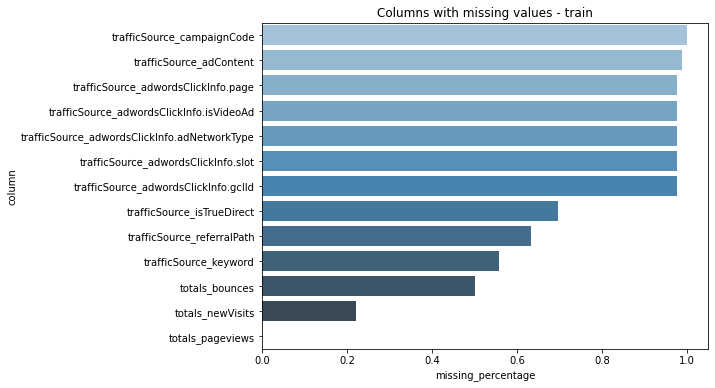

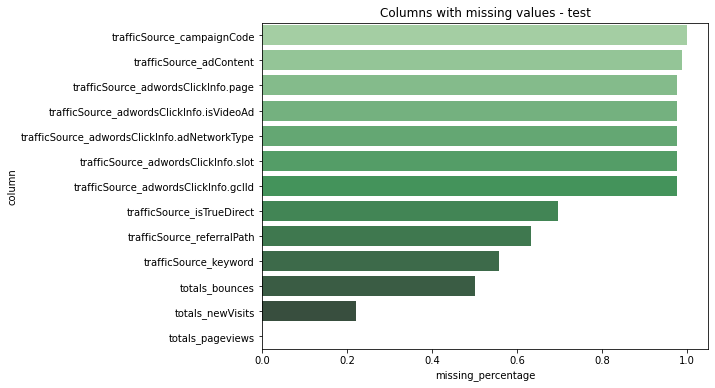

In [9]:
def missing_plot(frame, set_name, palette):
    nan_ratio = frame.isna().sum()/len(frame)
    nan_ratio = nan_ratio.to_frame().reset_index().rename({'index': 'column', 0: 'missing_percentage'},axis=1)
    nan_ratio.sort_values(by=['missing_percentage'], ascending=False, inplace=True)
    plt.figure(figsize=(8,6))
    plt.title("Columns with missing values - {}".format(set_name))
    ax = sns.barplot(x='missing_percentage', y='column', orient='h',
                     data=nan_ratio[nan_ratio['missing_percentage'] > 0],
                     palette= palette)

missing_plot(train, 'train', 'Blues_d')
missing_plot(train, 'test', 'Greens_d')

### 1.1.4 Columns with only 1 variable

In [10]:
train_const_cols = [c for c in train.columns if len(train[c].unique()) == 1]
test_const_cols = [c for c in test.columns if len(test[c].unique()) == 1]
print("{} columns with a unique value on train set".format(len(train_const_cols)))
print("{} columns with a unique value on test set".format(len(test_const_cols)))
print("Same columns for train and test set: ", train_const_cols == test_const_cols)
train.drop(train_const_cols, axis=1, inplace=True)
test.drop(test_const_cols, axis=1, inplace=True)
print("Shape after dropping: train {}, test {}".format(train.shape, test.shape))
# Flag visits with revenue
train['has_revenue'] = train['totals_transactionRevenue'].apply(lambda x: 1 if x > 0 else 0)

19 columns with a unique value on train set
19 columns with a unique value on test set
Same columns for train and test set:  True
Shape after dropping: train (903653, 36), test (804684, 34)


### 1.1.5 Channels and visit

In [11]:
def barplot_percentage(count_feat, color1= 'rgb(55, 83, 109)', 
                       color2= 'rgb(26, 118, 255)',num_bars= None):

    train_channel = 100*train[count_feat].value_counts()/len(train)
    train_channel = train_channel.to_frame().reset_index()
    test_channel = 100*test[count_feat].value_counts()/len(test)
    test_channel = test_channel.to_frame().reset_index()
    if num_bars:
        train_channel = train_channel.head(num_bars)
        test_channel = test_channel.head(num_bars)

    trace0 = go.Bar(
        x=train_channel['index'],
        y=train_channel[count_feat],
        name='Train set',
        marker=dict(color=color1)
    )
    trace1 = go.Bar(
        x=test_channel['index'],
        y=test_channel[count_feat],
        name='Test set',
        marker=dict(color=color2,)
    )

    layout = go.Layout(
        title='{} grouping'.format(count_feat),
        xaxis=dict(
            tickfont=dict(size=14, color='rgb(107, 107, 107)')
        ),
        yaxis=dict(
            title='Percentage of visits',
            titlefont=dict(size=16, color='rgb(107, 107, 107)'),
            tickfont=dict(size=14, color='rgb(107, 107, 107)')
        ),
        legend=dict(
            x=1.0,
            y=1.0,
            bgcolor='rgba(255, 255, 255, 0)',
            bordercolor='rgba(255, 255, 255, 0)'
        ),
        barmode='group',
        bargap=0.15,
        bargroupgap=0.1
    )

    fig = go.Figure(data=[trace0, trace1], layout=layout)
    iplot(fig)
barplot_percentage('channelGrouping')

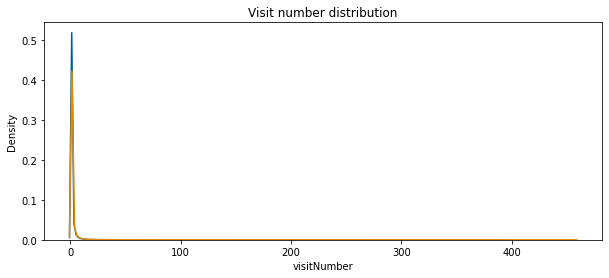

In [12]:
plt.figure(figsize=(10,4))
plt.title("Visit number distribution")
ax1 = sns.kdeplot(train['visitNumber'], label='Train set', color="#005c99")
ax2 = sns.kdeplot(test['visitNumber'], label='Test set', color="#e68a00")

The number of visits per user is almost the same for the train and test set



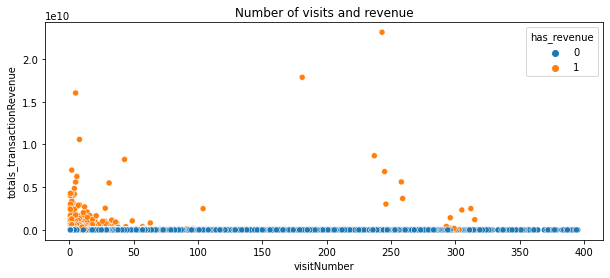

In [13]:
plt.figure(figsize=(10,4))
plt.title("Number of visits and revenue")
ax = sns.scatterplot(x='visitNumber', y='totals_transactionRevenue',
                     data=train,color='orange', hue='has_revenue') #[train['has_revenue'] > 0]

### 1.1.6 Location

In [14]:
def plotmap(frame, z_var, countries_col, title, colorscale, rcolor=True):

    data = [ dict(
            type = 'choropleth',
            autocolorscale = False,
            colorscale = colorscale,
            showscale = True,
            reversescale = rcolor,
            locations = frame[countries_col],
            z = frame[z_var],
            locationmode = 'country names',
            text = frame[countries_col],
            marker = dict(line = dict(color = '#fff', width = 2))
        )           
    ]

    layout = dict(
        height=680,
        #width=1200,
        title = title,
        geo = dict(
            showframe = False,
            showcoastlines = False,
            projection = dict(type = 'mercator'),
        ),
    )
    fig = dict(data=data, layout=layout)
    iplot(fig)

colorscale = [[0, 'rgb(102,194,165)'], [0.005, 'rgb(102,194,165)'], 
              [0.01, 'rgb(171,221,164)'], [0.02, 'rgb(230,245,152)'], 
              [0.04, 'rgb(255,255,191)'], [0.05, 'rgb(254,224,139)'], 
              [0.10, 'rgb(253,174,97)'], [0.25, 'rgb(213,62,79)'], [1.0, 'rgb(158,1,66)']]
    
# Plot world map - total visits
tmp = train["geoNetwork_country"].value_counts().to_frame().reset_index()
plotmap(tmp, 'geoNetwork_country', 'index', 'Total visits by Country', colorscale, False)

colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
        [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]]
# Plot world map - mean revenue
tmp = train.groupby("geoNetwork_country").agg({"totals_transactionRevenue" : "mean"}).reset_index()
plotmap(tmp, 'totals_transactionRevenue','geoNetwork_country', 'Mean revenue by country', colorscale)
# Plot world map - total revenue
tmp = train.groupby("geoNetwork_country").agg({"totals_transactionRevenue" : "sum"}).reset_index()
plotmap(tmp, 'totals_transactionRevenue','geoNetwork_country', 'Total revenue by country', colorscale)

### 1.1.7 Network domain

In [15]:
barplot_percentage('geoNetwork_networkDomain', num_bars= 10, 
                   color1='rgb(38, 115, 77)', color2='rgb(102, 204, 153)')

### 1.1.8 Totals

Revenue for bounce missing: 1540071240000, revenue for bounce '1': 0


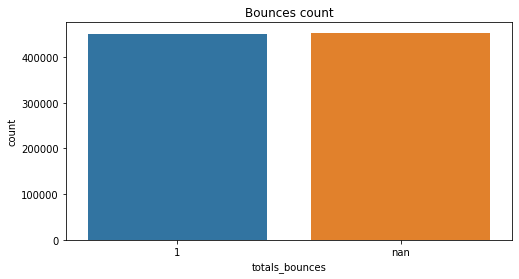

In [16]:
bounces_nan = train[train['totals_bounces'].isnull()]['totals_transactionRevenue'].sum()
bounces_1 = train[~train['totals_bounces'].isnull()]['totals_transactionRevenue'].sum()
print("Revenue for bounce missing: {}, revenue for bounce '1': {}".format(bounces_nan, bounces_1))
plt.figure(figsize=(8,4))
plt.title("Bounces count")
ax = sns.countplot(x='totals_bounces', data=train.fillna('nan'))

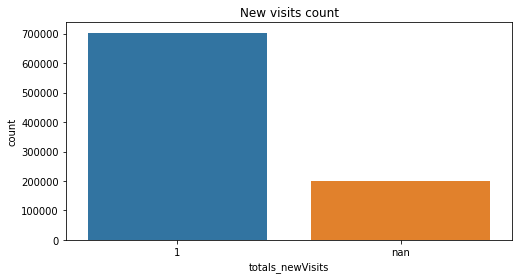

In [17]:
plt.figure(figsize=(8,4))
plt.title("New visits count")
ax = sns.countplot(x='totals_newVisits', data=train.fillna('nan'))

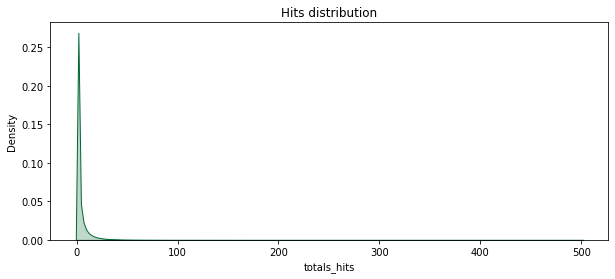

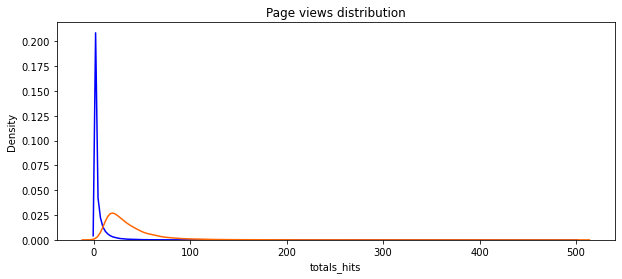

In [18]:
plt.figure(figsize=(10,4))
plt.title("Hits distribution")
ax1 = sns.kdeplot(train['totals_hits'].astype('float64'), color="#006633", shade=True)
plt.figure(figsize=(10,4))
plt.title("Page views distribution")
ax2 = sns.kdeplot(train[train['has_revenue'] == 0]['totals_hits'].astype('float64'),
                  label='No revenue', color="#0000ff")
ax2 = sns.kdeplot(train[train['has_revenue'] == 1]['totals_hits'].astype('float64'),
                  label='Has revenue', color="#ff6600")

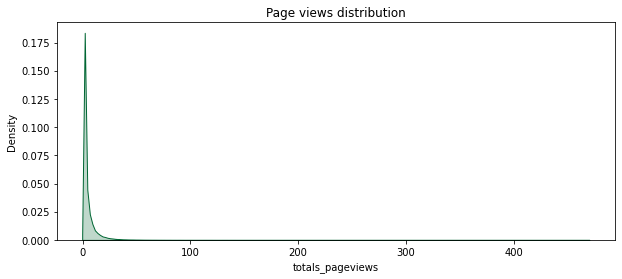

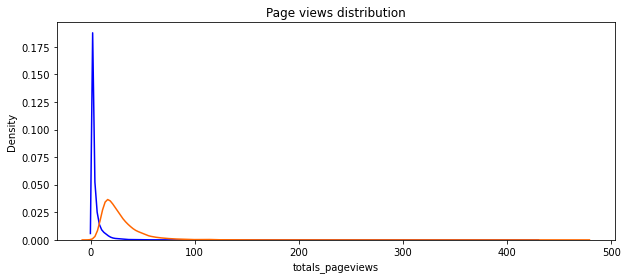

In [19]:
plt.figure(figsize=(10,4))
plt.title("Page views distribution")
ax3 = sns.kdeplot(train['totals_pageviews'].dropna().astype('float64'), color="#006633", shade=True)
plt.figure(figsize=(10,4))
plt.title("Page views distribution")
ax4 = sns.kdeplot(train[train['has_revenue'] == 0]['totals_pageviews'].dropna().astype('float64'),
                  label='No revenue', color="#0000ff")
ax4 = sns.kdeplot(train[train['has_revenue'] == 1]['totals_pageviews'].dropna().astype('float64'),
                  label='Has revenue', color="#ff6600")

### 1.1.9 Device

In [20]:
# Group and plot revenue
def group_revenue(group_col, title, sum_values=True, palette='Blues_d', size=(8,5)):
    if sum_values:
        tmp = train.groupby(group_col)['totals_transactionRevenue'].sum()
    else:
        tmp = train.groupby(group_col)['totals_transactionRevenue'].mean()
    tmp = tmp.to_frame().reset_index().sort_values('totals_transactionRevenue', ascending=False)
    tmp = tmp[tmp['totals_transactionRevenue'] > 0]
    plt.figure(figsize=size)
    plt.title(title)
    ax = sns.barplot(y=tmp[group_col], x= tmp.totals_transactionRevenue, orient='h', palette=palette)

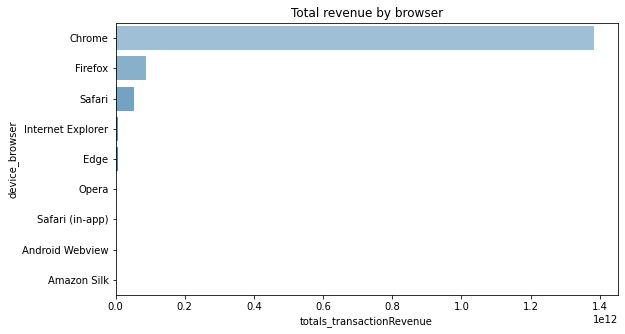

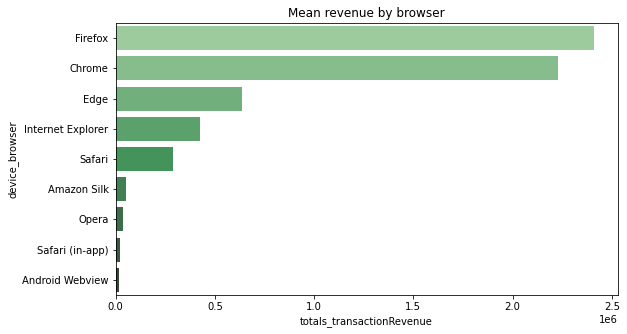

In [21]:
# Visits
barplot_percentage('device_browser', num_bars= 7)
# Revenue
group_revenue('device_browser', 'Total revenue by browser', True, size=(9,5))
group_revenue('device_browser', 'Mean revenue by browser', False, 'Greens_d',size=(9,5))

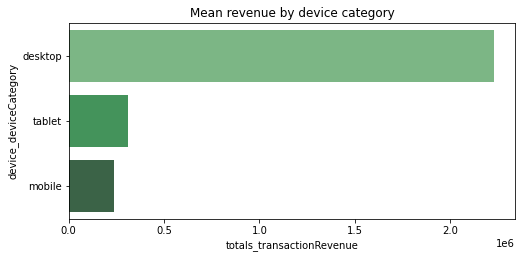

In [22]:
# Pie chart
colors = ['#5c8a8a', '#94b8b8', '#b3cccc']
dev_train = train['device_deviceCategory'].value_counts().to_frame().reset_index()
dev_test = test['device_deviceCategory'].value_counts().to_frame().reset_index()
trace1 = go.Pie(labels=dev_train['index'], values=dev_train.device_deviceCategory,
                domain= {'x': [0, .48]}, marker=dict(colors=colors))
trace2 = go.Pie(labels=dev_test['index'], values=dev_test.device_deviceCategory,
                domain= {'x': [0.52, 1]}, marker=dict(colors=colors))
layout = dict(title= "Device category - train and test", height=400)
fig = dict(data=[trace1, trace2], layout=layout)
iplot(fig)
# Revenue
group_revenue('device_deviceCategory', 'Mean revenue by device category', False, 'Greens_d', size=(8, 3.6))

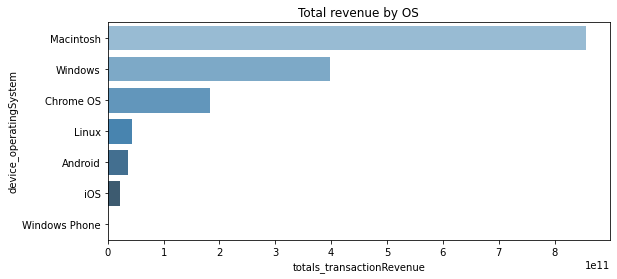

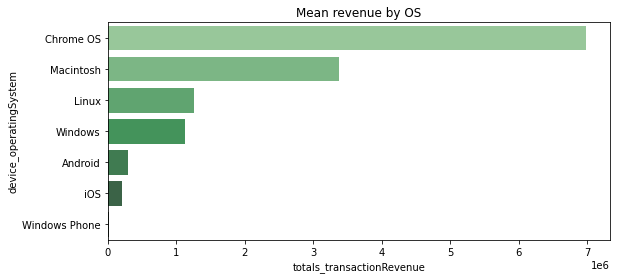

In [23]:
barplot_percentage('device_operatingSystem', num_bars = 7,
                   color1='rgb(204, 82, 0)', color2='rgb(255, 163, 102)')
# Revenue
group_revenue('device_operatingSystem', 'Total revenue by OS', True, 'Blues_d', size=(9, 4))
group_revenue('device_operatingSystem', 'Mean revenue by OS', False, 'Greens_d', size=(9, 4))

### 1.1.10 Summary
There are 12 original columns, but four of them have a json object that can be converted:

- device: 16 new columns
- geoNetwork: 11 new columns
- totals: 6 new columns
- trafficSource: 14 new columns (not yet)

## 1.2 Read data v2

In [24]:
train_v2 = pd.read_csv(dir + 'train_v2.csv', nrows=10)
train_v2.shape

(10, 13)

In [25]:
train_v1 = pd.read_csv(dir + 'train.csv', nrows=10)
train_v1.shape

(10, 12)

In [26]:
print('Train version01')
print(train_v1.columns)

Train version01
Index(['channelGrouping', 'date', 'device', 'fullVisitorId', 'geoNetwork',
       'sessionId', 'socialEngagementType', 'totals', 'trafficSource',
       'visitId', 'visitNumber', 'visitStartTime'],
      dtype='object')


In [27]:
print('Train version02')
print(train_v2.columns)

Train version02
Index(['channelGrouping', 'customDimensions', 'date', 'device',
       'fullVisitorId', 'geoNetwork', 'hits', 'socialEngagementType', 'totals',
       'trafficSource', 'visitId', 'visitNumber', 'visitStartTime'],
      dtype='object')


In [28]:
set(train_v1.columns).symmetric_difference(set(train_v2.columns))

{'customDimensions', 'hits', 'sessionId'}

## 1.3 Handle large dataset (using chunksize)

In [29]:
JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

dfs = pd.read_csv(dir + 'train_v2.csv', sep=',',
                 converters={column: json.loads for column in JSON_COLUMNS}, 
                 dtype={'fullVisitorId': 'str'}, # Important!!
                chunksize = 100000)
for df in dfs:
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    print(f"Shape: {df.shape}")

    for col in df.columns:
        df[col].to_csv(col + '.csv', mode='a', header=False, index=True)

    del df
    gc.collect()

Shape: (100000, 59)
Shape: (0, 25)
Shape: (0, 25)
Shape: (0, 25)
Shape: (0, 25)
Shape: (0, 25)
Shape: (0, 25)
Shape: (0, 25)
Shape: (0, 25)
Shape: (0, 25)
Shape: (0, 25)
Shape: (0, 25)
Shape: (0, 25)
Shape: (0, 25)
Shape: (0, 25)
Shape: (0, 25)
Shape: (0, 25)
Shape: (0, 25)


In [30]:
ls -lh 

total 1.3G
---------- 1 root root 828K Jun 28 03:04 __notebook__.ipynb
-rw-r--r-- 1 root root 1.7M Jun 28 02:56 channelGrouping.csv
-rw-r--r-- 1 root root 3.8M Jun 28 02:56 customDimensions.csv
-rw-r--r-- 1 root root 1.5M Jun 28 02:56 date.csv
-rw-r--r-- 1 root root 1.3M Jun 28 02:57 device.browser.csv
-rw-r--r-- 1 root root 3.5M Jun 28 02:57 device.browserSize.csv
-rw-r--r-- 1 root root 3.5M Jun 28 02:57 device.browserVersion.csv
-rw-r--r-- 1 root root 1.3M Jun 28 02:57 device.deviceCategory.csv
-rw-r--r-- 1 root root 3.5M Jun 28 02:57 device.flashVersion.csv
-rw-r--r-- 1 root root 1.2M Jun 28 02:57 device.isMobile.csv
-rw-r--r-- 1 root root 3.5M Jun 28 02:57 device.language.csv
-rw-r--r-- 1 root root 3.5M Jun 28 02:57 device.mobileDeviceBranding.csv
-rw-r--r-- 1 root root 3.5M Jun 28 02:57 device.mobileDeviceInfo.csv
-rw-r--r-- 1 root root 3.5M Jun 28 02:57 device.mobileDeviceMarketingName.csv
-rw-r--r-- 1 root root 3.5M Jun 28 02:57 device.mobileDeviceModel.csv
-rw-r--r-- 1 root roo

In [31]:
hits_df = pd.read_csv('hits.csv', nrows=1, header=None, index_col=0)
hits_df[1][0]

"[{'hitNumber': '1', 'time': '0', 'hour': '17', 'minute': '0', 'isInteraction': True, 'isEntrance': True, 'isExit': True, 'referer': 'https://www.google.co.uk/search?q=water+bottle&ie=utf-8&num=100&oe=utf-8&hl=en&gl=GB&uule=w+CAIQIFISCamRx0IRO1oCEXoliDJDoPjE&glp=1&gws_rd=cr&fg=1', 'page': {'pagePath': '/google+redesign/bags/water+bottles+and+tumblers', 'hostname': 'shop.googlemerchandisestore.com', 'pageTitle': 'Water Bottles & Tumblers | Drinkware | Google Merchandise Store', 'pagePathLevel1': '/google+redesign/', 'pagePathLevel2': '/bags/', 'pagePathLevel3': '/water+bottles+and+tumblers', 'pagePathLevel4': ''}, 'transaction': {'currencyCode': 'USD'}, 'item': {'currencyCode': 'USD'}, 'appInfo': {'screenName': 'shop.googlemerchandisestore.com/google+redesign/bags/water+bottles+and+tumblers', 'landingScreenName': 'shop.googlemerchandisestore.com/google+redesign/bags/water+bottles+and+tumblers', 'exitScreenName': 'shop.googlemerchandisestore.com/google+redesign/bags/water+bottles+and+tum

## 1.4 Handle large dataset (Using dask)